In [14]:
import torchgeo
from torchgeo.datasets import ChesapeakeCVPR
from torchgeo.datamodules import ChesapeakeCVPRDataModule
from torchgeo.trainers import SemanticSegmentationTask
from torchgeo.samplers import RandomGeoSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define some experiment parameters

experiment_dir = "results/"
experiment_name = "experiment_test"

batch_size = 32
learning_rate = 0.0001
gpu_id = 3
num_dataloader_workers = 24

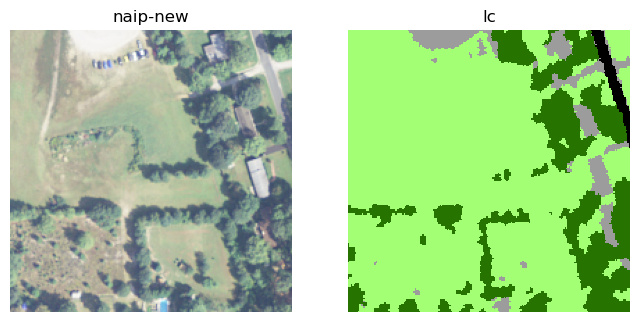

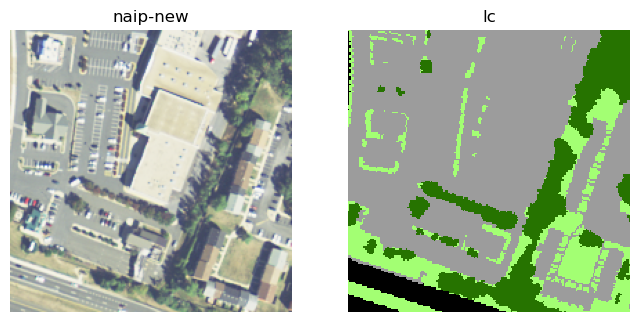

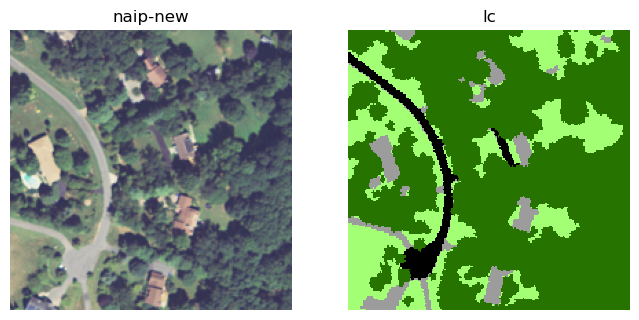

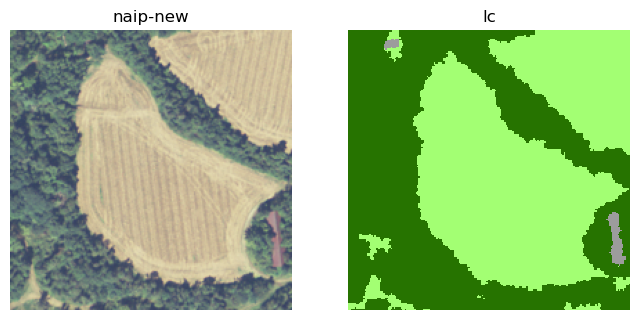

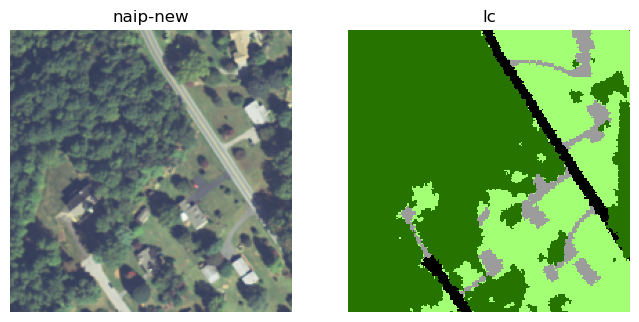

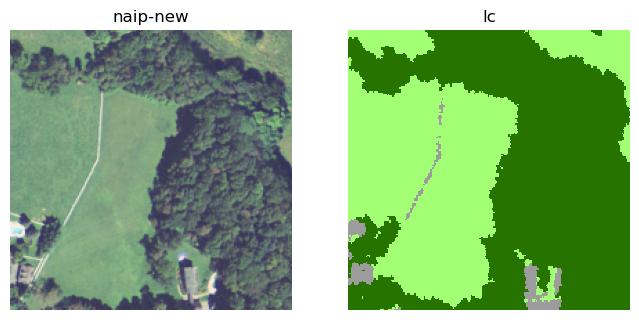

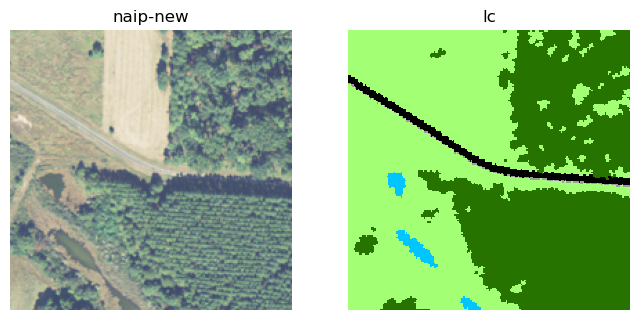

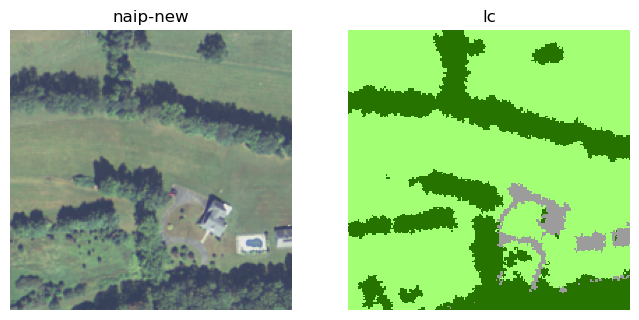

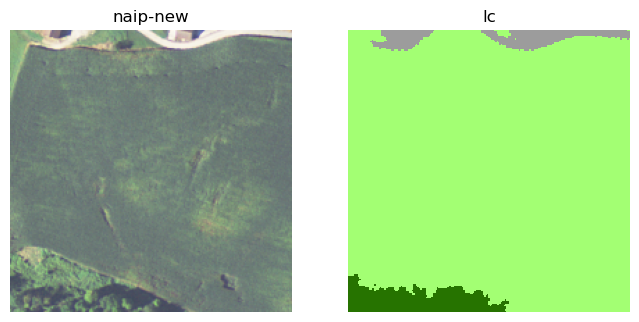

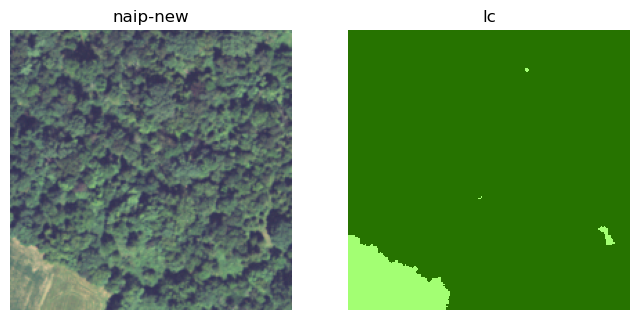

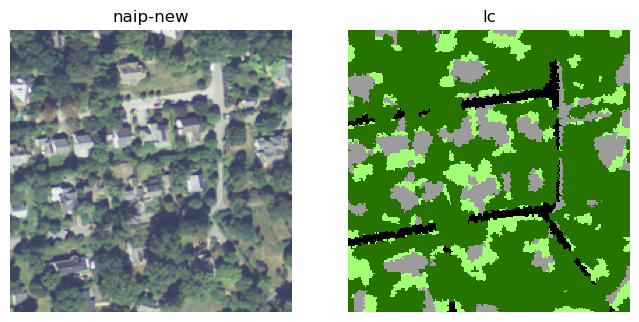

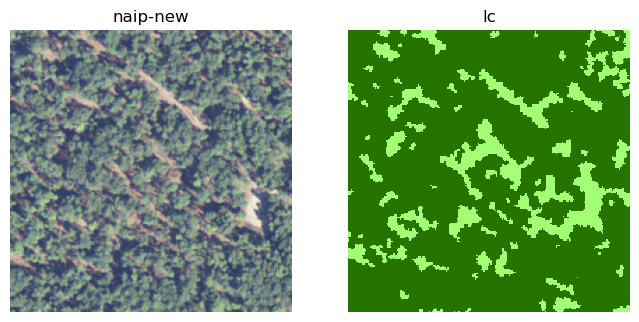

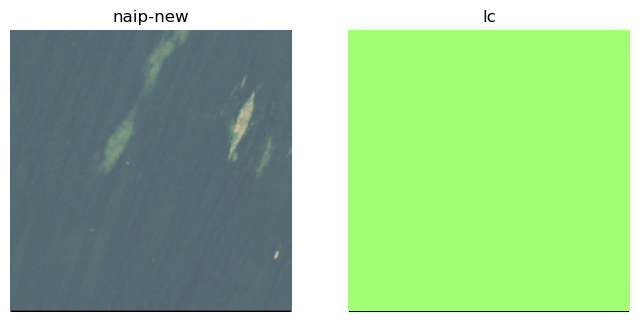

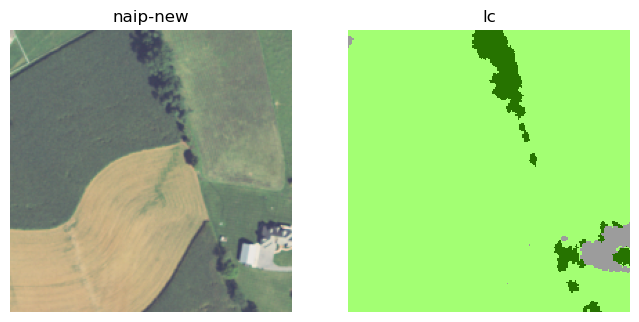

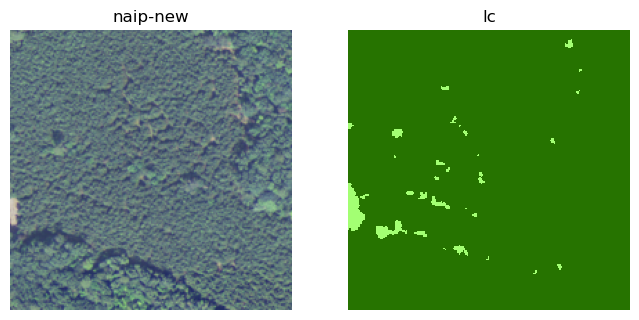

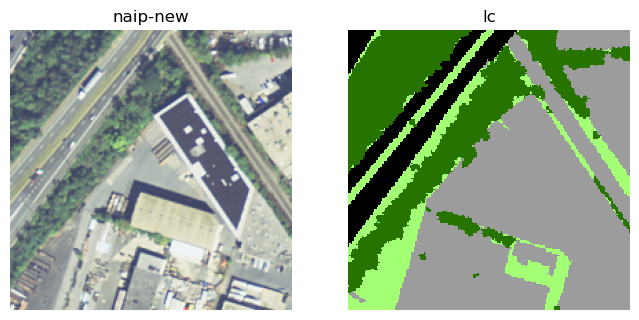

In [21]:
# Temporary, just for plotting
dataset = ChesapeakeCVPR(
    root="data/ChesapeakeCVPR/",
    splits=["md-train"],
    layers=["naip-new", "lc"],
)
sampler = RandomGeoSampler(dataset, size=256, length=16)

for bbox in sampler:
    dataset.plot(dataset[bbox])
    plt.show()
    plt.close()

In [10]:
datamodule = ChesapeakeCVPRDataModule(
    root="data/ChesapeakeCVPR/",
    num_workers=num_dataloader_workers,
    batch_size=batch_size,
    class_set=5,
    train_splits=["md-train"],
    val_splits=["md-val"],
    test_splits=["md-test"]
)

In [8]:
task = SemanticSegmentationTask(
    model="unet",
    backbone="resnet50",
    weights="imagenet",
    in_channels=4,
    num_classes=5,
    loss="ce",
    ignore_index=None,
    learning_rate=learning_rate,
    learning_rate_schedule_patience=10
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

tb_logger = TensorBoardLogger(
    save_dir="logs/",
    name=experiment_name
)

In [22]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[tb_logger],
    default_root_dir=experiment_dir,
    min_epochs=10,
    max_epochs=200,
    accelerator='gpu',
    devices=[gpu_id]
)

_ = trainer.fit(model=task, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/calebrobinson/.conda/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/calebrobinson/ssdprivate/torchgeo_dataset_integration_tests/results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 32.5 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total param

Sanity Checking: 0it [00:00, ?it/s]

/home/calebrobinson/.conda/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/home/calebrobinson/.conda/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
